# Pandas Introduction Part II  Pivot and Merge

<a target="_blank" href="https://colab.research.google.com/github/gawron/python-for-social-science/blob/master/pandas/bda_pandas_intro_part_2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Import all libraries needed for the tutorial

##import (library) as (give the library a nickname/alias)
import numpy as np
import pandas as pd  
# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
from pandas import DataFrame, read_csv

# The usual preamble when using matplotlib. 
# Most of the code we call is in pyplot.
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Loading Data

The next cell loads data from my website and will take some time to execute.  
It is slow because
it is retrieving a number of large uncompressed files containing year
by year babynames data,

In [2]:
import pandas as pd
years = list(range(1880,2011))
pieces = []
columns = ['name','sex','births']

url_path = 'https://raw.githubusercontent.com/gawron/'\
       'python-for-social-science/master/pandas/'
data_dir = 'names/'
for year in years:
    path = f'{url_path+data_dir}yob{year:d}.txt'
    frame = pd.read_csv(path,names=columns)
    frame['year'] = year
    pieces.append(frame)    
    
names = pd.concat(pieces, ignore_index=True)

## Pivot tables

### Introducing the pivot table

Suppose, as an aid to interpreting the numbers in the `'births'` column, we we are interest in the average popularity of a female name.  Then we want to find the mean births for all female names. 

We might proceed as follows. Pick a year, say 1881.

In [3]:
names[:5]

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [4]:
names1881 = names[names['year']  == 1881]

In [5]:
namesfemale1881 = names1881[names1881['sex'] == 'F']
namesfemale1881['births'].mean()

98.03304904051173

We might characterize this code as follows:

2. **Split step**: Line 1  **splits off** a group of rows, `namesfemale1881` using one of the possible values in `sex` column.  We'll call that column the **indexing** column.
3. **Apply step**: Line 2 **applies**  an **aggregation function**  ( `.mean()` ) to the `'births'` column of those rows; call `births` the **values** column.


In this example we performed the **split** step on one of
the possible values in the indexing column, then performed **apply step**
on one group of rows.
As we saw with cross-tabulation. we  frequently want to perform these two steps for all possible values in the
indexing column.  

And of course that leads to the need for combining: we want to **combine** the results in a new
Data Structure, indexed by the values that defined our groups  In our example,
the indexing column is `'sex'` with possible values `'F'` and `'M`', so
we'd like a new DataFrame with a single column containing the `'births'` means for those groups.

Summarizing: we need to **split** the DataFrame into groups of rows  (using an index column),
**apply** (applying an aggregation function to a values column), and **combine** (into a DataFrame).
These are exactly the steps we executed for cross-tabulation.  The difference
in this case is that instead of just counting the groups of rows, we want to
apply the aggregation function to the *values* column `'births'` .
It turns out this variation on the three steps comes up often  enough to merit a name.

All three steps can be performed using **pivot table** method.

In [32]:
pt = names1881.pivot_table(values= 'births',index='sex',aggfunc='mean')

In [6]:
pt

,births
sex,
F,98.033049
M,101.051153


In fact, `mean` is the default aggregation function, and the first and second
arguments of the `.pivot_table()` method are always the values column and the index
column, so we get the same result by writing:

In [7]:
pt = names1881.pivot_table('births','sex')
pt

,births
sex,
F,98.033049
M,101.051153


It is worth emphasizing the importance of the **combine** step;
the `.pivot_table()` method combines its results into
a **DataFrame**. That means we can leverage all our knowledge
of how DataFrames work in using it, for example, by plotting the results.  One of the key takeaways about `pandas`
is that almost all the functions and methods that apply to DataFrames and Series
return either a DataFrame or a Series.  By understanding
the properties of what's returned, we can use it more effectively in
the next analytical step.

As desired, the values in the `'sex'` column now index the new DataFrame:

In [8]:
pt.index

Index(['F', 'M'], dtype='object', name='sex')

Note the original name of the indexing column has been preserved,
as the above output shows. It is stored in the `name` attribute 
of the DataFrame index:

In [9]:
pt.index.name

'sex'

As with any DataFrame, `.loc[ ]`  is used to access individual rows using names
from the index.

In [10]:
# Any expression containing this is a KeyError
# pt['sex']
# because 'sex' is not the name of a column in `pt`.
pt.loc['F']

births    98.033049
Name: F, dtype: float64

We have just found the **mean** female and male births for 1881.

Suppose we want **total births** instead of mean births.  It can still be done 
with a pivot table, and we still need to group by sex, and apply an aggregation functiomn to the values
column, but we need to change our **aggregation function** from `mean` to `sum`.

In [11]:
names1881.pivot_table('births','sex',aggfunc='sum')

,births
sex,
F,91955
M,100748


How many male and female names were there in 1881? We've answered this question
before a different way.

Idea We're still splitting into groups.  We're just going to count the
sizes of each group, that is, the number of rows in each group ( so we don't need a numerical column).

In [12]:
names1881.pivot_table('name','sex',aggfunc='count')

,name
sex,
F,938
M,997


Th choice of the first argument doesn't matter,  We're just using it to have objects to count
in each group

In [20]:
names1881.pivot_table('births','sex',aggfunc='count')

,births
sex,
F,938
M,997


In fact, the first argument can be omitted by using keywords to identify all
the other arguments; since we haven't fixed a column to
do counting on, this produces a 3-column DataFrame.

In [522]:
names1881.pivot_table(index='sex',aggfunc='count')

,births,name,year
sex,,,
F,938,938,938
M,997,997,997


Here, with  no `NaN`s in the data, each column contains the same counts; to get
just the group sizes with no individual column-value counts, use `size` as the aggfunc.
This produces a Series, reporting the number of rows in each group.

In [521]:
names1881.pivot_table(index='sex',aggfunc='size')

sex
F    938
M    997
dtype: int64

So now we know the total number of male and female births in 1881 (at least
those accounted for our data sample).

Of course we could have gotten this result another easier way (also returning a `Series`).

In [13]:
names1881["sex"].value_counts()

M    997
F    938
Name: sex, dtype: int64

But let's continue along these lines, because
there are plenty of things a pivot table can do that a value_counts operation
can't, for example the mean birth counts by gender above.


For example,
suppose we want to find birth totals by gender and by year. That is,  we want a new DataFrame in which 
rows are indexed by year and there are two columns showing the total births for `'F'` and `'M'` in each year.  
Fot that we need to move back to the `names` DataFrame, which includes all years.

So we want the following **pivot table**:

In [33]:
total_births = names.pivot_table('births','year', columns='sex', aggfunc='sum')

In [34]:
total_births.head()

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445


Of course we could just as easily have the index values be genders and the columns be years.

In [513]:
total_births2 = names.pivot_table('births','sex', columns='year', aggfunc='sum')
#only showing the first 10 of 131 columns
total_births2.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,90993,91955,107851,112322,129021,133056,144538,145983,178631,178369
M,110493,100748,113687,104632,114445,107802,110785,101412,120857,110590


The difference between these two pivot table computations lies entirely
in the combine step.

Under the hood, both DataFrames require computing the same row groups and applying `'sum'` to the `births` column in each group.

In fact, `total_births2` is the transpose of `total_births`.

In [621]:
import numpy as np
np.all(total_births2.T == total_births)

True

Thus in `total_births`, we find the 2006 birth totals with `.loc[]`:

In [55]:
total_births.loc[2006]

sex
F    1896468
M    2050234
Name: 2006, dtype: int64

In `total_births2`, we access the  same 2006 birth totals the way we access any column.

In [25]:
total_births2[2006]

sex
F    1896468
M    2050234
Name: 2006, dtype: int64

Since `total_births` and `total_births2` contain essentially the same information,
let's summarize what we learned about the `.pivot_table()` method with
`total_births`.

How was `total_births` created?  By three steps

1. Splitting the rows of `name` into groups  (one for each year, gender pair).
2. Applying the aggregation function `sum` to each group
3. Combining the results into a single DataFrame `total_births`.

This is the now familiar the split/apply/combine strategy.  

#### Cross tab versus pivot_table

Compare `total_births` with the output of `pd.crosstab`, which we use to get the joint distribution counts for two attributes; although the rows and columns are the same, the 
numbers are different.

In [35]:
# Shd have been computed above
#total_births = names.pivot_table('births','year', columns='sex', aggfunc='sum')
total_births[:5]

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445


In [36]:
crosstab_year_sex = pd.crosstab(names['year'],names['sex'])
crosstab_year_sex[:5]

sex,F,M
year,,
1880,942,1058
1881,938,997
1882,1028,1099
1883,1054,1030
1884,1172,1125


**Exercise**

Describe what each set of numbers captures.

**Model exercise answer**

The groupings used in the two operations are exactly the same (hence the index and column names are the same).
For both operations each group of rows represents a year/gender pair.
The `crosstab` operation simply counts the number of rows in each group;
hence, each value in the crosstab table represents the number of **names** of a particular gender
for a particular year.  On the other hand, the pivot table computes the sum of the values in the `births` column 
for each year/gender pair, which is the total number of **births** for that year and that gender.

Continuing the pivot_table/crosstab comparison, there is a also transposed version of the `crosstab`
table we just did:

The transposed pivot table:

In [4]:
total_births2.iloc[:,:5]

year,1880,1881,1882,1883,1884
sex,,,,,
F,90993,91955,107851,112322,129021
M,110493,100748,113687,104632,114445


The transposed `crosstab` table:

In [7]:
crosstab_sex_year = pd.crosstab(names['sex'],names['year'])
crosstab_sex_year.iloc[:,:10]

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889
sex,,,,,,,,,,
F,942,938,1028,1054,1172,1197,1282,1306,1474,1479
M,1058,997,1099,1030,1125,1097,1110,1067,1177,1111


In [512]:
crosstab_sex_year[1880]['F']

942

To nail down the special task for which `pd.crosstab` is designed:

In general, `pd.crosstab` takes any two sequences of equal length
(which in our case were two columns from a `DataFrame`) and
computes how many times unique pairings  occur.  

```
[1,0,1,0,0,1,1]
[b,b,b,a,b,a,a]
```
For example, in the two arrays seen here, a `1` from the first sequence is paired with a `b` from the second twice.  The results are summarized in the cross-tabulation DataFrame. 

In [25]:
pd.crosstab(np.array([1,0,1,0,0,1,1]),np.array(['b','b','b','a','b','a','a']),colnames=["let"],rownames=["num"])

let,a,b
num,,
0,1,2
1,2,2


If the two sequences are columns from a DataFrame, then the counts tell us how many
rows contain each possible pairing of values.  So each pair of values defines
a group of rows (the rows with `'year'` 1881 and `'sex'` 'F', for example, in `names`).
Note that we have provided no values column
providing numbers to perform an aggregation operation on.  All we do is
compute the row groups and count their sizes.

Now there is one curve ball, mentioned here because you may
come across code that uses it: `pd.crosstab` has an optional `values` argument.
In lieu of just counting the rows in a group,  we can apply an aggregation operation to the 
values column of the row groups.

For example we can use `crosstab` to
recreate `total_births`, the DataFrame we created
above with `pivot_table`.  Here is the DataFrame we created with `pivot_table`.

In [18]:
total_births.iloc[:10]

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
1885,133056,107802
1886,144538,110785
1887,145983,101412
1888,178631,120857


And here is the same DataFrame using `crosstab`.

In [19]:
# Specify sum as the aggregation function
# and births as the numerical value column for sum to apply to
ct_table = pd.crosstab(names['year'], names['sex'],values= names['births'],aggfunc='sum')
ct_table.iloc[:10]

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
1885,133056,107802
1886,144538,110785
1887,145983,101412
1888,178631,120857


So it is possible to use `crosstab` to create a
`pivot_table` type DataFrame.

It's not clear to me why this extensive overlap in functionality exists.  But in general
your code will be easier to understand if you restrict use of `crosstab` to group
counting and use `pivot_table` whenever aggregation functions and a value column
are needed.

## Plotting

All data frames have a `plot` method; for
a simple DataFrame like a pivot table
the the `plot` method draws a very simple picture. 

Consider plotting `total_births`, the pivot table created in a previous
section.  Here's the DataFrame.  Note the index and the two columns:

In [20]:
total_births

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
...,...,...
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310


And here is the default plot, which puts the index on the x-axis and plots the two columns
as separate line plots.

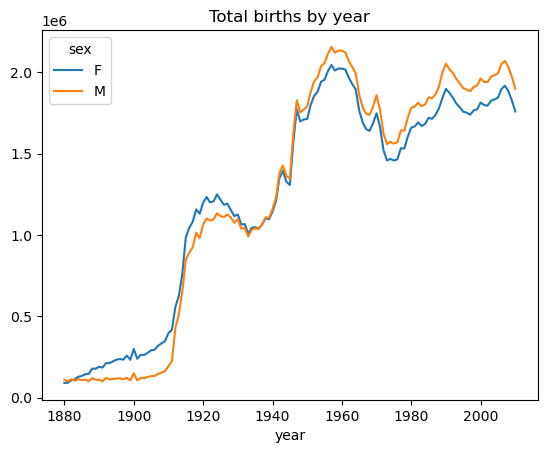

In [40]:
total_births.plot(title='Total births by year') 
plt.show()

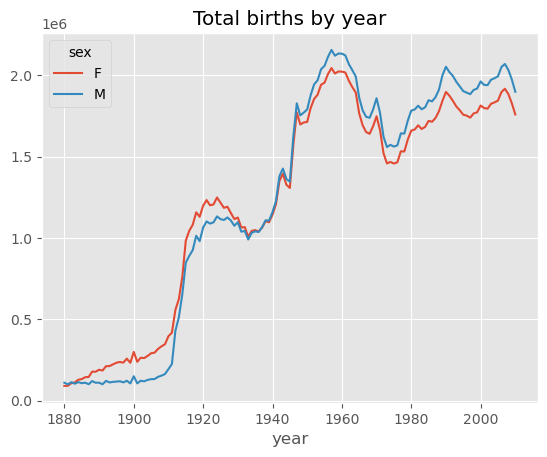

In [37]:
import matplotlib as mpl
from matplotlib import pyplot as plt

with mpl.style.context(['ggplot']):
    total_births.plot(title='Total births by year') 
    plt.show()

## Alternative plotting script

The above graph is great and often what we want is just to take a quick look at the relationships in the data, and the default DataFrame plot will do exactly the right thing with no customization.  It's helpful to know that `pandas` is using a Python package called `matplotlib` to draw the graph above, and we can do the same ourselves, with a lot more lines of code, but also with a lot more customization options.

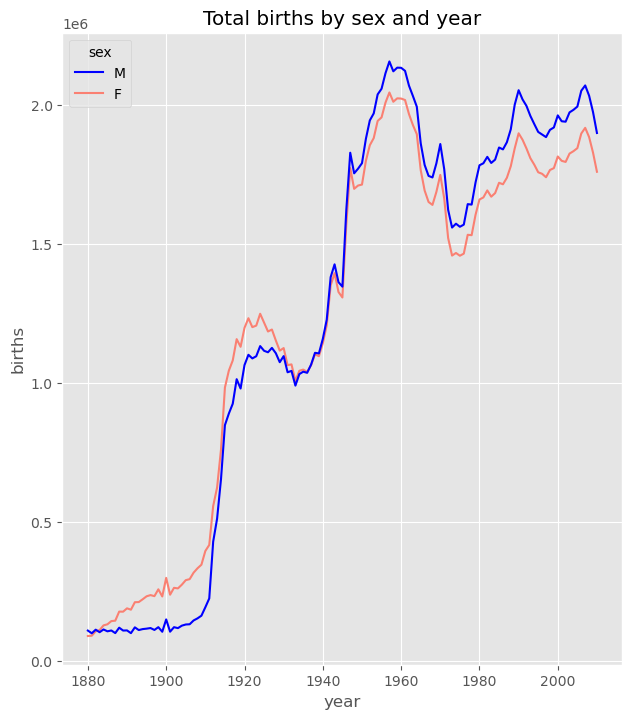

In [21]:
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
with mpl.style.context(['ggplot']):
    fig = plt.figure(1,figsize=(8,8))
    ax1 = fig.add_subplot(111)
    fig.subplots_adjust(top=0.9,left=0.2)
    ax1.set_ylabel('births')

    ax1.set_xlabel('year')
    (p1,) = ax1.plot(total_births.index,total_births['F'],color='salmon',label='F')
    (p2, ) = ax1.plot(total_births.index,total_births['M'],color='blue',label='M')
    ax1.set_title('Total births by sex and year')

    ax1.legend((p2,p1),('M','F'),loc='upper left',title='sex')
    plt.show()

The basic requirement for the `matplotlib.plot(...)` function 
is that you need to supply two sequences of the same length giving the x- and y- 
coordinates respectively of the plot. We can optionally specify plot attributes like line
style, color, and label (for use in the legend) for each line plotted. 

There are also other plot functions which could provide alternative views of the 
relationships.

For example, we could do this as a bar plot. 

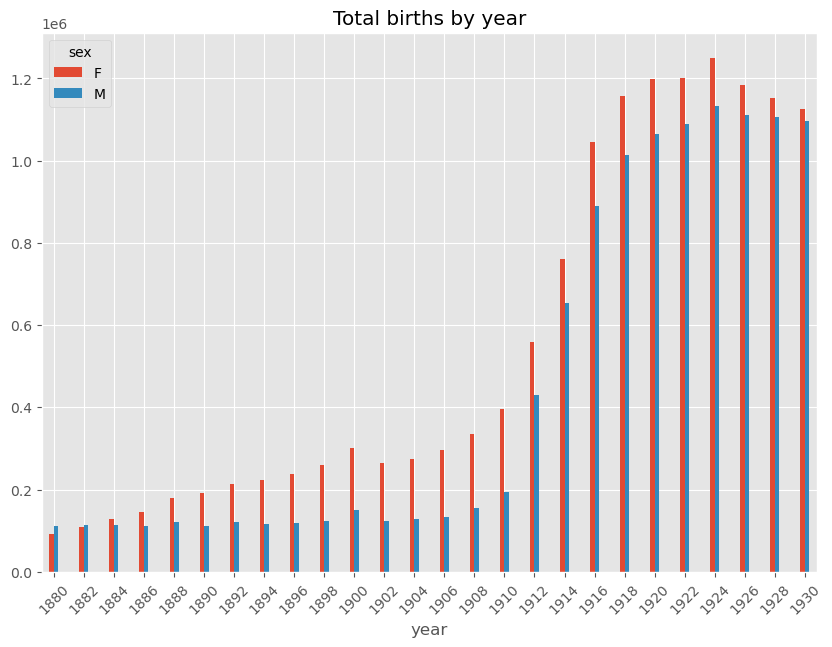

In [56]:
import matplotlib as mpl
from matplotlib import pyplot as plt

with mpl.style.context(['ggplot']):
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    width,rot=.3,45
    total_births.loc[1880:1930:2].plot(kind="bar",title='Total births by year',width=width,rot=rot,ax=ax1) 
    plt.show()

Yoy can try the plot above with more years, but you'll see that the bars and the x-axis
get quite crowded.  

Here is an alternative tinkering a bit with `matplotlib`'s parameters.

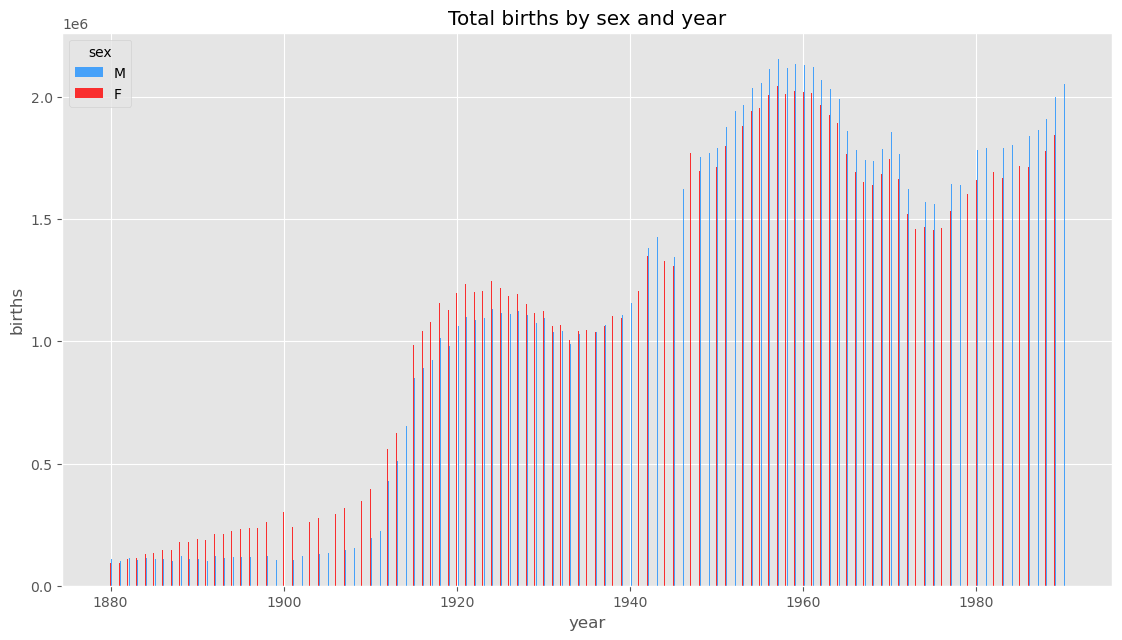

In [535]:
import matplotlib.pyplot as plt
import matplotlib as mpl

with mpl.style.context(['ggplot']):
    
    fig = plt.figure(1,figsize=(15,7))
    ax1 = fig.add_subplot(111)
    fig.subplots_adjust(top=0.9,left=0.2)
    ax1.set_ylabel('births')

    ax1.set_xlabel('year')
    width=.1
    inc = (width)*1.5
    data = total_births.loc[1880:1990]
    ax1.bar(data.index+inc,data['M'],color='dodgerblue',width=width, label='M',alpha=.8)
    ax1.bar(data.index,data['F'],color='red',label='F',width=width,alpha=.8)
    ax1.set_title('Total births by sex and year')

    ax1.legend(loc='upper left',title='sex')
    plt.show()

## Using pivot instead of groupby

As we discussed in the Pandas I Notebook, splitting (or grouping) is the first of the three operations in the split/apply/combine strategy.

We used the NBA dataset to illustrate, because it has some very natural
groupings.

We reload the NBA dataset.

In [41]:
import pandas as pd
import urllib.error

url_path  = 'https://gawron.sdsu.edu/python_for_ss/course_core/'
data_dir = 'data/'

github_url_path ='https://raw.githubusercontent.com/gawron/python-for-social-science/master/pandas/'
github_data_dir = 'datasets/'

nba_file = "nba.csv"
nba_file_url = url_path + data_dir + nba_file


try:
    print(f"Reading {nba_file_url}")
    nba_df = pd.read_csv(nba_file_url)
except urllib.error.HTTPError:
    print("HTTPError Handled!")
    nba_file_url = github_url_path + github_data_dir + nba_file
    print(f"Reading {nba_file_url}")
    nba_df = pd.read_csv(nba_file_url)

Reading https://gawron.sdsu.edu/python_for_ss/course_core/data/nba.csv


Some of the questions we answered there could have been done with a pivot table:

For example, let's use a pivot table to answer the question about average weight of centers in one step.

In [23]:
nba_df[:5]

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,6-10,231.0,NaN,5000000.0


In [24]:
with pd.option_context("display.precision",3):
    nba_pt_wt = nba_df.pivot_table(values='Weight',index='Position')
    print(nba_pt_wt)

print(f"\nAnd the average weight of centers is: {nba_pt_wt.loc['C','Weight']:.2f}")

           Weight
Position         
C         254.205
PF        240.430
PG        189.478
SF        221.776
SG        206.686

And the average weight of centers is: 254.21


The numbers here are means because mean is the default aggregation function.  Similarly, consider the question:

What position  earns the highest salary on average?

The pivot table answer, going all the way to the highest valued position:

In [42]:
# Get pivot table; sort values for the Salary column, get first element of index
nba_df.pivot_table(values='Salary',index='Position')['Salary'].sort_values(ascending=False).index[0]

'C'

And here's the pivot table that answer came from, indexed by position with a single `Salary` column
that contains the mean of our position groups.

In [43]:
nba_df.pivot_table(values='Salary',index='Position')

,Salary
Position,
C,5.967052e+06
PF,4.562483e+06
PG,5.077829e+06
SF,4.857393e+06
SG,4.009861e+06


The point is that `pivot_table`, like `pd.crosstab`, executes the split-apply-combine
strategy in one step and so it will often be more convenient to call `pivot_table`
rather than `groupby`.

The `.groupby()` method is the first step in creating a pivot table; hence, we can always emulate
the effect of `.pivot_table()` by grouping and then applying an aggregation function.

However, if we're after
only one aggregation operation for a particular grouping, there really isn't an advantage to using `groupby`. 
We may as well use `pivot_table`.

One final point: An important extension of what we've done so far is to define our row groups
by pairs of column values, much as we did with cross-tabulation, with a third column providing
the values we are taking the mean of.  In the final example, we find each team's average salary
for each position: The DataFrame index is team and the columns belong to positions.   So each  value represents the mean value of the Salary column for a group of rows defined by a position and a team.

In [540]:
nba_df.pivot_table(values='Salary',columns="Position", index='Team')[:7]

Position,C,PF,PG,SF,SG
Team,,,,,
Atlanta Hawks,7.585e+06,5.988e+06,4.882e+06,3.000e+06,2.608e+06
Boston Celtics,2.450e+06,6.057e+06,4.975e+06,6.796e+06,2.108e+06
Brooklyn Nets,1.032e+07,3.576e+06,2.916e+06,NaN,1.473e+06
Charlotte Hornets,6.772e+06,4.686e+06,4.776e+06,6.331e+06,4.661e+06
Chicago Bulls,1.042e+07,3.361e+06,1.117e+07,1.958e+06,5.718e+06
Cleveland Cavaliers,6.829e+06,1.394e+07,6.552e+06,1.196e+07,3.762e+06
Dallas Mavericks,2.332e+06,3.053e+06,4.418e+06,8.231e+06,8.928e+06


Can you construct a differenty pivot tables that represents the same information with a multilevel index
instead of 5 columns?

In [27]:
nba_df.pivot_table(values='Salary',index=['Team',"Position"])[:7]

Salary
Team           Position              
Atlanta Hawks  C         7.585417e+06
               PF        5.988067e+06
               PG        4.881700e+06
               SF        3.000000e+06
               SG        2.607758e+06
Boston Celtics C         2.450465e+06
               PF        6.056987e+06

### New Stocks dataset:  Working with Time


In [2]:
import pandas as pd
import os.path
import urllib.request 
import os.path
from matplotlib import pyplot as plt

url_path = 'https://raw.githubusercontent.com/gawron/'\
       'python-for-social-science/master/pandas/'
github_tutorial_dir = 'tutorial/pycon-pandas-tutorial-master/data/time/'
stock_file = 'stocks.csv'
stock_file_url = url_path + github_tutorial_dir + stock_file
print(f"Reading {stock_file_url}")
time1 = pd.read_csv(stock_file_url, index_col=0)

time1

Reading https://raw.githubusercontent.com/gawron/python-for-social-science/master/pandas/tutorial/pycon-pandas-tutorial-master/data/time/stocks.csv


,date,AA,GE,IBM,MSFT
0,1990-02-01 00:00:00,4.98,2.87,16.79,0.51
1,1990-02-02 00:00:00,5.04,2.87,16.89,0.51
2,1990-02-05 00:00:00,5.07,2.87,17.32,0.51
3,1990-02-06 00:00:00,5.01,2.88,17.56,0.51
4,1990-02-07 00:00:00,5.04,2.91,17.93,0.51
...,...,...,...,...,...
5467,2011-10-10 00:00:00,10.09,16.14,186.62,26.94
5468,2011-10-11 00:00:00,10.30,16.14,185.00,27.00
5469,2011-10-12 00:00:00,10.05,16.40,186.12,26.96
5470,2011-10-13 00:00:00,10.10,16.22,186.82,27.18


There are no NaN  values in the data.

In [45]:
len(time1), len(time1.dropna())

(5472, 5472)

To get the feel of this data set try this:

**Plotting challenge**:  Plot IBM and GE stock prices for February.  

Note: even though the values in the `'date'` column are strings, they've very well chosen strings
for our purposes.  Normal string sorting will reproduce chronological order.

Note you will have to use the `'date'` column, which contains times represented as strings

In [47]:
time1['date'][0]

'1990-02-01 00:00:00'

Now to get the data for a month we **could** do our grouping by hand, as in the following cell,
which zooms in on February.

In [48]:
time_feb = time1[(time1['date'] >='1990-02-01 00:00:00') & 
                 (time1['date'] < '1990-03-01 00:00:00') ]

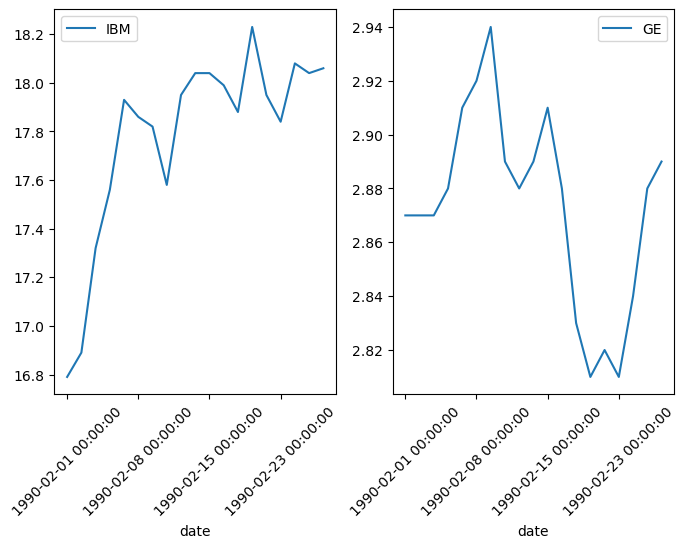

In [49]:
(fig,(ax0,ax1)) = plt.subplots(1,2, figsize=(8,5))
time_feb.plot('date','IBM',ax=ax0,rot=45)
time_feb.plot('date','GE',ax=ax1,rot=45)
plt.show()

But DataFrames with a time series column provide certain time-specfic services that will make this
much easier.  So let's convert the `date` column to pandas Timestamp instances as we read it in.

In [50]:
time3 = pd.read_csv(stock_file_url,index_col=0,converters={"date":pd.Timestamp})

Note the type conversion could also be done after reading in the data:

```
time4 = pd.read_csv(stock_file_url,index_col=0)
time4['date'] = pd.to_datetime(time5['date'])
```

This may be more efficient with large datasets.

In [54]:
time3

,date,AA,GE,IBM,MSFT
0,1990-02-01,4.98,2.87,16.79,0.51
1,1990-02-02,5.04,2.87,16.89,0.51
2,1990-02-05,5.07,2.87,17.32,0.51
3,1990-02-06,5.01,2.88,17.56,0.51
4,1990-02-07,5.04,2.91,17.93,0.51
...,...,...,...,...,...
5467,2011-10-10,10.09,16.14,186.62,26.94
5468,2011-10-11,10.30,16.14,185.00,27.00
5469,2011-10-12,10.05,16.40,186.12,26.96
5470,2011-10-13,10.10,16.22,186.82,27.18


The objects in the date column are now Pandas Timestamp objects, which are inspired by and very closely related to
Python's DateTime objects (imported with the `datetime` module).  They represent moments in time defined
by a specific date and time.  The month, year, hour, minute, and second of a `TimeStamp` instance can all
be retrieved with methods of the same name:

In [53]:
# TimeStamp instance 
dt = time3['date'][0]
print(dt, type(dt))
print('Month  ',dt.month)
print('Hour   ', dt.hour)
print('Day    ', dt.day)
# Feb 1 1990 was on a Thursday (Monday is day 0)
print('Weekday', dt.weekday())
# Print it out nice using format codes from datetime module
print(dt.strftime('%a %b %d %Y %H:%M:%S'))


1990-02-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Month   2
Hour    0
Day     1
Weekday 3
Thu Feb 01 1990 00:00:00


As with columns containing strings, `pandas` supplies vectorized operations on any `DateTime` column.

With columns containing string data we needed to use the `.str` method before invoking a vectorized string method.
For example

```
df[col_name].str.lower()
```

The use of `.str` tell pandas that what follows is a string method and that it should be applied to 
the `Series` `df[col]` in a vectorized fashion.

The analogue of `str` for dates is `dt`.

In [341]:
# We get the year of every timestamp instance in the column
time3['date'].dt.year

0       1990
1       1990
2       1990
3       1990
4       1990
        ... 
5467    2011
5468    2011
5469    2011
5470    2011
5471    2011
Name: date, Length: 5472, dtype: int64

In most cases the easiest way to do selection via the `date` column uses `.dt` as well.

To get the rows with February 1992 dates we do:

In [55]:
feb1992 = time3[(time3['date'].dt.month == 2) & 
                (time3['date'].dt.year == 1992)]
feb1992[:5]

,date,AA,GE,IBM,MSFT
506,1992-02-03,5.56,3.75,17.20,2.05
507,1992-02-04,5.58,3.80,17.36,2.04
508,1992-02-05,5.52,3.83,17.17,2.08
509,1992-02-06,5.48,3.83,17.14,2.07
510,1992-02-07,5.52,3.82,17.02,2.06


Let's use this restricted DataFrame to do a day by day plot for Feb 1992 for two different stocks.

We  want the x-axis to be the date column (not the index, which is the default), so
we have to tell the plot function both what to plot as x and what to plot as y.

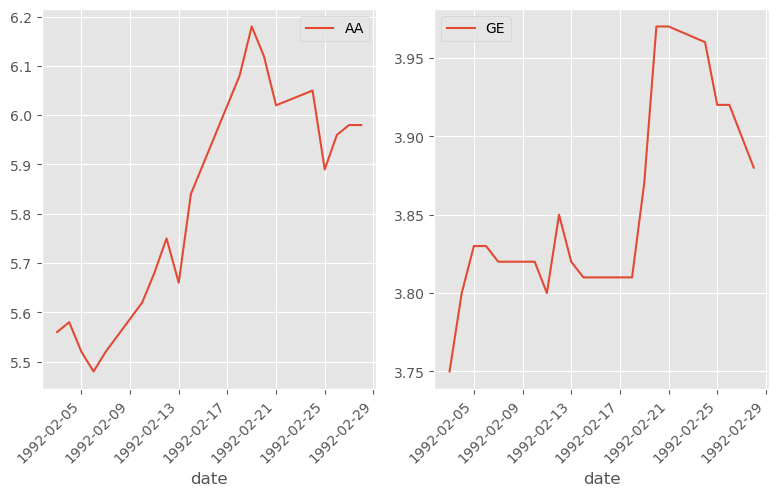

In [56]:
with mpl.style.context(['ggplot']):
    # Subplot array is 1x2 1 row with 2 cols.
    (fig, (ax1,ax2))  = plt.subplots(1,2,figsize=(8,5))
    # More room between subplots
    fig.tight_layout()
    feb1992.plot('date','AA',rot=45,ax=ax1)
    feb1992.plot('date','GE',rot=45,ax=ax2)
    plt.show()

If we want to group by month, what we usually want to do is group
by year and month.  There are different way to do this, but one is to construct
a column of year-month date strings from the date column with the `dt.strftime()` method.
This method takes as an argument a **date format string** containing date format codes that
specify the particular types of datetime information needed.

In the first row of the example output below, the format string `"%Y %b"` extracts the year `"1992"`
because of the format code `"%Y"`, and the abbreviated month name `"Feb"`
because of the format code `%b`.  For a complete list of 
formatting codes, look [here](https://strftime.org/) or search for **format code** in [the datetime module docs.](https://docs.python.org/3/library/datetime.html)

In [58]:
month_str_series = time3['date'].dt.strftime("%Y %b")
month_str_series[15:26]

15    1990 Feb
16    1990 Feb
17    1990 Feb
18    1990 Feb
19    1990 Mar
20    1990 Mar
21    1990 Mar
22    1990 Mar
23    1990 Mar
24    1990 Mar
25    1990 Mar
Name: date, dtype: object

Using this `Series` we can create a group object in which each group of rows
corresponds to a particular calendar month.  Note that we do not
need to make the `Series` a column of `time3` in order to use it to
index a grouping of `time3`.  

In [59]:
#month_groups3 = time3.groupby([time3['date'].dt.year,time3['date'].dt.month])
#month_str_series = time3['date'].dt.strftime("%Y %b")
month_groups3 = time3.groupby(month_str_series)

We need to supply a year-month string to identify any given group:

In [61]:
month_groups3.get_group("1990 Feb")

,date,AA,GE,IBM,MSFT
0,1990-02-01,4.98,2.87,16.79,0.51
1,1990-02-02,5.04,2.87,16.89,0.51
2,1990-02-05,5.07,2.87,17.32,0.51
3,1990-02-06,5.01,2.88,17.56,0.51
4,1990-02-07,5.04,2.91,17.93,0.51
5,1990-02-08,5.04,2.92,17.86,0.51
6,1990-02-09,5.06,2.94,17.82,0.52
7,1990-02-12,4.96,2.89,17.58,0.52
8,1990-02-13,4.91,2.88,17.95,0.52
9,1990-02-14,4.94,2.89,18.04,0.52


Now let's apply an aggregation function to the grouping object:

In [62]:
#This is a DataFrame
mean_by_months3 = month_groups3[["AA","GE","IBM","MSFT"]].mean()
mean_by_months3

,AA,GE,IBM,MSFT
date,,,,
1990 Apr,5.141000,3.037500,18.767500,0.638500
1990 Aug,5.245217,3.065217,18.349130,0.665652
1990 Dec,4.784000,2.723500,20.354000,0.812500
1990 Feb,5.043684,2.873158,17.781579,0.523158
1990 Jul,5.511905,3.420476,20.613810,0.800000
...,...,...,...,...
2011 Jun,15.390000,18.295000,164.875455,24.299091
2011 Mar,16.485217,19.596522,159.020435,25.237391
2011 May,16.806190,19.493810,168.752381,24.820476


The index of the `mean_by_months3` DataFrame  is calendar months.
Each entry represents the mean sales price of a particular company's stock for the month in the index.

We can now plot the mean price for all the companies in the data
across all the months.

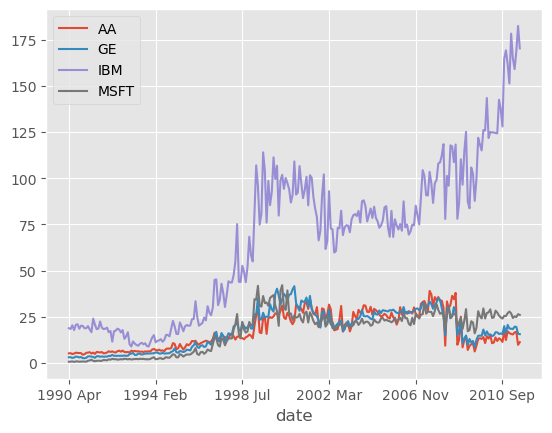

In [63]:
with mpl.style.context(['ggplot']):
    mean_by_months3.plot()
    plt.show()

As in our non temporal examples, we can circumvent the grouping step and directly construct the
mean by months DataFrame by using `pd.pivot_table`.

In [64]:
new_mean_by_months3 =\
    pd.pivot_table(time3, index=month_str_series,
                   values=time3.columns[-4:], aggfunc='mean')
new_mean_by_months3

,AA,GE,IBM,MSFT
date,,,,
1990 Apr,5.141000,3.037500,18.767500,0.638500
1990 Aug,5.245217,3.065217,18.349130,0.665652
1990 Dec,4.784000,2.723500,20.354000,0.812500
1990 Feb,5.043684,2.873158,17.781579,0.523158
1990 Jul,5.511905,3.420476,20.613810,0.800000
...,...,...,...,...
2011 Jun,15.390000,18.295000,164.875455,24.299091
2011 Mar,16.485217,19.596522,159.020435,25.237391
2011 May,16.806190,19.493810,168.752381,24.820476


The `new_mean_by_months3` DataFrame is equivalent to the one
we constructed with `.groupby()` and `.mean()`.

In [579]:
(mean_by_months3 == new_mean_by_months3).all()

AA      True
GE      True
IBM     True
MSFT    True
dtype: bool

And of course it produces exactly the same plot.

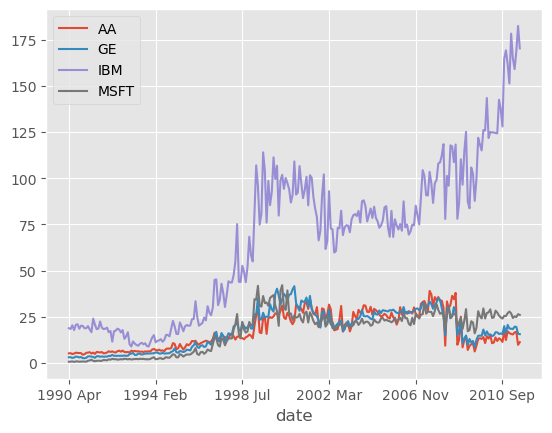

In [580]:
with mpl.style.context(['ggplot']):
    new_mean_by_months3.plot()
    plt.show()

###  Redoing everything we just did using a DateTimeIndex instead of a DateTime column

Because time series data is so important in data analysis of all kinds
(from business trends analysis to scientific data analysis), `pandas` 
supplies various special purpose tools for handling temporal data. 
In the discussion above, we saw how one such tool,
the `pandas` `timestamps.Timestamp` type (the type of the `date` column
in `time3`), could facilitate an array of tasks from grouping at different
temporal granularities, to plotting and doing some elementary statistical
analysis.

Another time-specific tool allows us to construct a DataFrame with a **DatetimeIndex**.  The general
motivation for  using a `DatetimeIndex` is that each row in our data can be associated with a unique time.
This is true of our stock data, for example, because each row represents stock prices
for a particular day.  In that case, it is easy make the times serve as the **index** of our DataFrame.

Let's quickly step through everything we just did with one initial choice
altered.  We will promote our date data to be the index of the DataFrame.
Everything we just did can still be done with some minor 
variants, and in some ways things are simplified.

The point of going through the dates-as-column alternative first was that
it pretty much stuck to the ideas we had developed in previous examples,
and helped underline the point that dealing with with times does not
involve anything earth-shakingly new.  Nevertheless dates do introduce
some special features (grouping by month, hour, or minute for example)
and some of the customized tools `pandas` introduces for DateTime indexes
are quite useful.

To make our our original `date` column (which contains date strings) into an
an index, we assign it a special type `pd.DateTimeIndex`,
and then promote it to be the index of the DataFrame.

In [72]:
time2 = pd.read_csv(stock_file_url,index_col=0,converters={"date":pd.Timestamp})
time2 = time2.set_index('date')

We now have a dataFrame for which DateTime objects are the index.

In [66]:
time2[:6]

,AA,GE,IBM,MSFT
date,,,,
1990-02-01,4.98,2.87,16.79,0.51
1990-02-02,5.04,2.87,16.89,0.51
1990-02-05,5.07,2.87,17.32,0.51
1990-02-06,5.01,2.88,17.56,0.51
1990-02-07,5.04,2.91,17.93,0.51
1990-02-08,5.04,2.92,17.86,0.51


We can extract a specific row using a string to identify the day we want:

In [73]:
time2.loc['1990-02-05']

AA       5.07
GE       2.87
IBM     17.32
MSFT     0.51
Name: 1990-02-05 00:00:00, dtype: float64

And somewhat surprisingly, you can pick a particular calendar month as follows:

In [70]:
feb_1992 = time2.loc['1992-02']
feb_1992[:5]

,AA,GE,IBM,MSFT
date,,,,
1992-02-03,5.56,3.75,17.20,2.05
1992-02-04,5.58,3.80,17.36,2.04
1992-02-05,5.52,3.83,17.17,2.08
1992-02-06,5.48,3.83,17.14,2.07
1992-02-07,5.52,3.82,17.02,2.06


Just to be clear, our index consists of pandas `Timestamp` instances

In [585]:
time2.index[0]

Timestamp('1990-02-01 00:00:00')

But pandas supports printing them like strings.

In [68]:
print(time2.index[0])

1990-02-01 00:00:00


And, as we just saw in the previous query `time2.loc['1992-02']`, 
pandas supports identifying particular dates or groups of dates with strings.

So `time2.loc['1992-02']` retrieves the same rows as the value assigned in the next cell:

In [587]:
feb1992a = time2[(time2.index.month == 2) & 
                  (time2.index.year == 1992)]

As before, we can do the day by day plot for Feb 1992 for two different stocks.

Since the datetimes are the index, all we need to do is identify the
column we want to follow day by day:

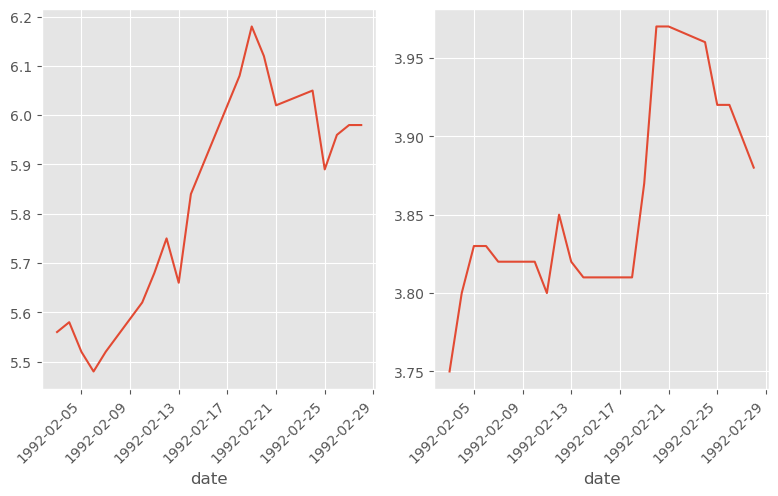

In [74]:
with mpl.style.context(['ggplot']):
    # Subplot array is 1x2 1 row with 2 cols.
    (fig, (ax1,ax2))  = plt.subplots(1,2,figsize=(8,5))
    # More room between subplots
    fig.tight_layout()
    # Rotate the xaxis labels 45 degrees to get them to display nicer.
    feb_1992['AA'].plot(rot=45,ax=ax1)
    feb_1992['GE'].plot(rot=45,ax=ax2)
    plt.show()

To do grouping by times on a DataFrame with a datetime index,  we use the  `resample` method;
this is basically a `group_by` operation in which the groups are defined by some temporal property.

So to group by months as we did before, we do:

In [75]:
month_groups=time2.resample('M')

We don't need to say anything about years; `pandas` understands that the most natural way to
group times by month is to have each group contain all the days from one month in a particular year.

Month groups are not referenced by pairs of months and years, but by the last day of each month group,
and since 1992 is a leap year:

In [76]:
month_groups.get_group('1992-02-29')[:5]

,AA,GE,IBM,MSFT
date,,,,
1992-02-03,5.56,3.75,17.20,2.05
1992-02-04,5.58,3.80,17.36,2.04
1992-02-05,5.52,3.83,17.17,2.08
1992-02-06,5.48,3.83,17.14,2.07
1992-02-07,5.52,3.82,17.02,2.06


Next we find the means for each month, which works 
much the same as getting means for `groupby` instances.

In [78]:
#This is a DataFrame
mean_by_months = month_groups.mean()
mean_by_months[:5]

,AA,GE,IBM,MSFT
date,,,,
1990-02-28,5.043684,2.873158,17.781579,0.523158
1990-03-31,5.362273,2.963636,18.466818,0.595000
1990-04-30,5.141000,3.037500,18.767500,0.638500
1990-05-31,5.278182,3.160000,20.121818,0.731364
1990-06-30,5.399048,3.275714,20.933810,0.821429


This looks a lot like `mean_by_months3`, the DataFrame
we got from `time3`, in which the dates were a column.

And here is the mean by months plot.  The code is
identical to what we did for the `time3` mean plot,
but the x-axis renders differently because
the index of `mean_by_months` is a DateTime Index.

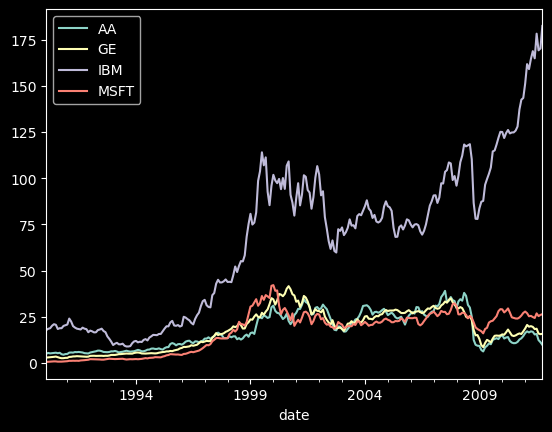

In [79]:
with mpl.style.context(['dark_background']):
    mean_by_months.plot()
    plt.show()

As before, we can replace the grouping plus the statistical aggregation
operation with a single pivot table call, though in this
case we can't use the convenient group-indexing parameter `"M"`
to index by month, so we use a `Series` of year-month strings
constructed with `.strftime()` and an appropriate format string.

In [596]:
new_mean_by_months =\
    pd.pivot_table(time2, index=time2.index.strftime("%Y %b"),
                   values=time2.columns[-4:], aggfunc='mean')
# Convert index back from string to pd.Timestamp
new_mean_by_months = new_mean_by_months.set_index(pd.to_datetime(new_mean_by_months.index))
new_mean_by_months

,AA,GE,IBM,MSFT
date,,,,
1990-04-01,5.141,3.038,18.768,0.638
1990-08-01,5.245,3.065,18.349,0.666
1990-12-01,4.784,2.724,20.354,0.812
1990-02-01,5.044,2.873,17.782,0.523
1990-07-01,5.512,3.420,20.614,0.800
...,...,...,...,...
2011-06-01,15.390,18.295,164.875,24.299
2011-03-01,16.485,19.597,159.020,25.237
2011-05-01,16.806,19.494,168.752,24.820


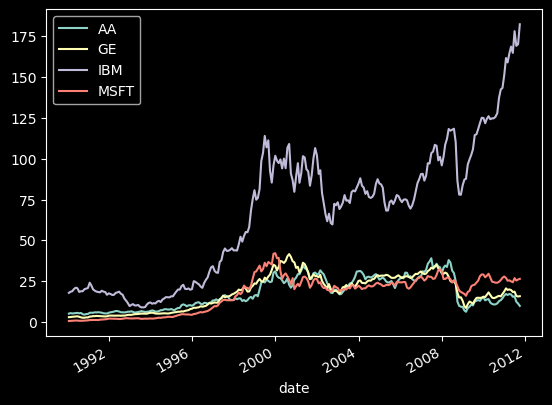

In [597]:
with mpl.style.context(['dark_background']):
    new_mean_by_months.plot(rot=30)
    plt.show()

### Reviewing and summarizing the discussion above using this example

We start with two different ways of representing the time data. First, use a datetime column:

```
time3 = pd.read_csv(stock_file_url),converters={"date":pd.Timestamp})
```

Second, make the time data be the index:

```
time2 = pd.read_csv(stock_file_url),converters={"date":pd.Timestamp})
time2 = time2.set_index('date') 
```

We then performed the same actions for the two representations
in a variety of basic use cases:

| Action | Datetime Column  |  Datetime Index   |
| :-- | :-: | :-: |
| select month |  feb1992 = time3[(time3['date'].dt.month == 2) & (time3['date'].dt.year == 1992)]   | feb1992a = time2.loc['1992 Feb'] |
| plotting month | feb1992.plot('date','AA') | feb_1992a['AA'].plot() |
| grouping | month_str_series = time3['date'].dt.strftime("%Y %b") | month_groups2 = time2.resample('M')|
|          | month_groups3 = time3.groupby(month_str_series) |
| group means | mean_by_months3 = month_groups3[["AA","GE","IBM","MSFT"]].mean()| mean_by_months2 = month_groups2.mean() |
| plot means | mean_by_months3.plot() | mean_by_months2.plot() |


The moral:  Because time is often the axis
we use to locate or group other variables, and because panda provides special purpose
tools for that case, using Datetime index can often simplify things.

The caveat:  It doesn't always work well to make the temporal information be the index.
For example, in the Covid cases data loaded below, the same date is associated with
many rows in the DataFrame.  In that case it's useful to know how to deal
with temporal columns.

We have barely scratched the surface of the functionality pandas provides for handling times.
For more depth and breadth [the pandas TimeSeries docs.](https://pandas.pydata.org/docs/user_guide/timeseries.html)

## Introducing Merging

In this section we introduce `pandas` merging function, which merges the data
in two different DataFrames into one DataFrame.  

We will look at an example that illustrates the simplest case, the
case where the indexes of the two DataFrames agree.
The operation is very much like the following operation in
`numpy`:

In [2]:
import numpy as np
## Prepare a1
a1 = np.ones((3,4))
a1[1] =np.zeros(4,)
print("a1")
print(f"{a1}")
print()
## Prepare a2
a2 = np.zeros((3,5))
a2[1] = np.ones((5,))
print("a2")
print(f"{a2}")
print()
# Merge
a1_a2_cnct = np.concatenate([a1,a2],axis=1)
print("np.concatenate([a1,a2],axis=1)")
print(f"{a1_a2_cnct}")

a1
[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]]

a2
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]

np.concatenate([a1,a2],axis=1)
[[1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0.]]


We concatenate columnwise, adding the columns of the second array to columns of the first, resulting in 
a new array with 9 columns.

The pandas merge operation will be very
similar, except that in pandas merging, the order of the rows won't matter.  The sole
guide for aligning the rows will be indexes of the
two DataFrames.

We begin by loading the first of our two DataFrames, which contains LifeSatisfaction data
on many countries.

In [3]:
import pandas as pd
import importlib.util
import os.path

# Where the data is
notebook_lifesat_url0 = 'https://github.com/gawron/python-for-social-science/'\
'blob/master/pandas/datasets/lifesat/'


# Derive the appropriate URL for data download.
lifesat_url = notebook_lifesat_url0.replace('github', 'raw.githubusercontent')
lifesat_url = lifesat_url.replace('blob/','')
oecd_file = 'oecd_bli_2015.csv'

def load_url_data (url,data_file,**params):
    #oecd_file = 'oecd_bli_2015.csv'
    file_url= f'{url}{data_file}'
    #Deal with number formatting in data file
    return pd.read_csv(file_url, **params)#thousands=',',encoding='utf-8')

oecd_bli = load_url_data(lifesat_url,oecd_file, thousands=",",encoding='utf-8')
# Get appropriate subset
oecd_bli = oecd_bli[(oecd_bli["INEQUALITY"]=="TOT")& (oecd_bli["Country"] !='OECD - Total')]

This table contains economic and social statistics for people in a number of countries.  The `INEQUALITY` attribute contains statistics for subpopulations like low/high income, men/women.  Since we won't be looking at those sub-populations in this section, the first step after reading in the data is to reduce the table to those 
rows containing statistics about the total population.

The data in this big table is stored in an interesting and very popular format. Let's understand that 
before moving on.  First there are facts about 36 distinct countries.  One of the names in the `Country`
column  (`OECD - Total`) is a label under which totals for all the countries will be aggregated.

In [4]:
countries = oecd_bli['Country'].unique()
print(f'{len(countries)} countries in data')
print (countries)

36 countries in data
['Australia' 'Austria' 'Belgium' 'Canada' 'Czech Republic' 'Denmark'
 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland'
 'Italy' 'Japan' 'Korea' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Slovak Republic' 'Spain' 'Sweden'
 'Switzerland' 'Turkey' 'United Kingdom' 'United States' 'Brazil' 'Chile'
 'Estonia' 'Israel' 'Russia' 'Slovenia']


The cell below shows what happens when we zoom in on one country, Poland,
and four columns. The table contains a number of rows with information about Poland, each with a different value in the  `Indicator` column.  That column contains the name of some statistic.  The numerical value for that statistic is in the `Value` column and the unit for that statistic and the unit is in the `UNIT CODE` (or `Unit`) column.  So the first row printed out tells us that 3.2% of all households in Poland are dwellings without basic facilities, an indicator of substantial poverty.

In [5]:
pol = oecd_bli[oecd_bli["Country"]=="Poland"]
pol[['Country','Indicator','Unit','Value']].iloc[:,:12]
#pol.iloc[:,:12]

,Country,Indicator,Unit,Value
21,Poland,Dwellings without basic facilities,Percentage,3.20
130,Poland,Housing expenditure,Percentage,21.00
239,Poland,Rooms per person,Ratio,1.10
348,Poland,Household net adjusted disposable income,US Dollar,17852.00
531,Poland,Household net financial wealth,US Dollar,10919.00
640,Poland,Employment rate,Percentage,60.00
825,Poland,Job security,Percentage,7.30
936,Poland,Long-term unemployment rate,Percentage,3.77
1121,Poland,Personal earnings,US Dollar,22655.00
1306,Poland,Quality of support network,Percentage,91.00


We can use the `pivot` method to recast the data into a much easier to grasp format.  The key point is that each country and INDICATOR determines a specific value.  So let's have one row for each country with one column for each `INDICATOR`, and in that column we'll place the `VALUE` associated with that country and that indicator.  It's as easy as this:

In [7]:
oecd_bli_pt = oecd_bli[['Country','Indicator','Unit','Value']].pivot_table(index="Country", 
                                                                           columns="Indicator", 
                                                                           values="Value")
# Looking at one row (type Series)
oecd_bli_pt.loc['Poland']

Indicator
Air pollution                                   33.00
Assault rate                                     1.40
Consultation on rule-making                     10.80
Dwellings without basic facilities               3.20
Educational attainment                          90.00
Employees working very long hours                7.41
Employment rate                                 60.00
Homicide rate                                    0.90
Household net adjusted disposable income     17852.00
Household net financial wealth               10919.00
Housing expenditure                             21.00
Job security                                     7.30
Life expectancy                                 76.90
Life satisfaction                                5.80
Long-term unemployment rate                      3.77
Personal earnings                            22655.00
Quality of support network                      91.00
Rooms per person                                 1.10
Self-reported heal

Now each column specifies an indicator.

In [148]:
oecd_bli_pt.columns[0]

'Air pollution'

Looking back to compare one value in the original DF, with the derived data in the pivot:

In [149]:
poland = oecd_bli[oecd_bli['Country']=='Poland']
poland[poland['Indicator']  == 'Dwellings without basic facilities']['Value']

21    3.2
Name: Value, dtype: float64

In [150]:
oecd_bli_pt.loc['Poland','Dwellings without basic facilities']

3.2

What is weird about what we just did with `pivot_table` is that we chose no aggregation operation.

The example above is not an outlier.  For every country/indicator pair, the value in the `'Value'` column in the original DataFrame is
exactly the same as the value in the corresponding row and column of the pivot table.
It appears as if no aggregation operation has taken place!

Actually appearances are deceiving.  What has happened is that in this particular data set
all the row groups we get by pairing country and indicator are of size 1; the default
aggregation operation is mean and when we take the mean of a single number we get that number back.

So what is the point of creating a pivot table then?  

1. We've made the value in the country column the index.  We need a DataFrame with
   the countries as index for the merge we will do below.
2. We've restructured the data into a more comprehensible  (and more easily manipulated)   
   format;  and that is an important function of the pivot table operation.  


## A column of particular interest

In future exercises with this data, we're going to take particular interest in the `Life satisfaction` score,  a kind of general "quality of life" or "happiness" score computed from a formula combining the indicators in this data. 

That is, it is a value computed from the other values in the same row.  In a regression
context, we would think of this as the dependent variable, the variable whose value
we try to compute as some function of the others.

In [8]:
oecd_bli_pt["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

# Load and prepare GDP per capita data

Elsewhere, on the world wide web, with help from Google, we find data about GDP  ("gross domestic product")
[here](http://goo.gl/j1MSKe).

This is the second of the two DataFrames we will merge.

This is a very simple data frame with columns containing various
useful country-specific pieces of information.  Since there is one row per
country, we have made the `'Country`' column the index.

In [9]:
# Downloaded data from http://goo.gl/j1MSKe (=> inf.org) to github

gdp_file = "gdp_per_capita.csv"
#load_url_data(lifesat_url,oecd_file, thousands=",",encoding='utf-8')
gdp_per_capita = load_url_data (lifesat_url,gdp_file,
                                delimiter="\t",
                                encoding="latin1",
                                na_values="n/a",
                                thousands=",")


gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita["Country"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea-

In [10]:
# Make "Country" the index column.  We are going to merge data on this column.
excl_val = 'International Monetary Fund, World Economic Outlook Database, April 2016'
gdp_per_capita = gdp_per_capita[gdp_per_capita["Country"] != excl_val]
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       ...
       'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe'], dtype='object', name='Country', length=189)

In [11]:
gdp_per_capita["GDP per capita"]

Country
Afghanistan              599.994
Albania                 3995.383
Algeria                 4318.135
Angola                  4100.315
Antigua and Barbuda    14414.302
                         ...    
Venezuela               7744.746
Vietnam                 2088.344
Yemen                   1302.940
Zambia                  1350.151
Zimbabwe                1064.350
Name: GDP per capita, Length: 189, dtype: float64

Note that this is a superset of the index of the pivot table we created above.

In [12]:
non_oecd = set(gdp_per_capita.index) - set(oecd_bli_pt.index)
print(len(non_oecd),  len(oecd_bli_pt),len(gdp_per_capita), )
'Tunisia' in non_oecd

153 36 189


True

In [156]:
set(oecd_bli_pt.index) - set(gdp_per_capita.index)

set()

 ### Merging two data sources  on their indexes
 
 We now engage in the great magic, the single most important operation by which information is created, the `merge`.
 We are going to take the quality of life data, which is indexed by country, and the GDP data, now also indexed
 by country, and  merge rows, producing one large table which contains all the rows and columns of the `oecd_bli` table,
 as well some new columns merged in from `gdp_per_capita`.

In [13]:
#full_country_stats2 = pd.merge(left=oecd_bli_pt, right=gdp_per_capita, 
#                              )
#MergeError: No common columns to perform merge on. 
#Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [15]:
full_country_stats = oecd_bli_pt.merge(gdp_per_capita, 
                              left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", ascending=False,inplace=True)
oecd_bli_pt.shape,gdp_per_capita.shape,full_country_stats.shape

((36, 24), (189, 6), (36, 30))

The many countries in the gdp index but not in the life satisfaction index
were ignored.

We have a new DataFrame combining the columns of the two merged DataFrames:

Last column of `oecd_bli_pt`:

In [13]:
oecd_bli_pt.iloc[:5,-1:]

Indicator,Years in education
Country,
Australia,19.4
Austria,17.0
Belgium,18.9
Brazil,16.3
Canada,17.2


Last seven columns of the result of the merge.

In [16]:
full_country_stats.iloc[:5,-7:]

,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,
Luxembourg,15.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",101994.093,2014.0
Switzerland,17.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",80675.308,2015.0
Norway,17.9,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",74822.106,2015.0
United States,17.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",55805.204,2015.0
Denmark,19.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",52114.165,2015.0


Equivalently the merge can be done with a Pandas function:

```
full_country_stats = pd.merge(left=oecd_bli_pt, right=gdp_per_capita, 
                              left_index=True, right_index=True)
                              
```

The effect of changing the DataFrame that calls the method is simply to change the order of
the columns.  The columns of the calling DataFrame go on th eleft.

```
full_country_stats = gdp_per_capita.merge(oecd_bli_pt, left_index=True, right_index=True)
```

Finally, the easiest way to accomplish this particular merge is to use the `DataFrame.join()` method,
Its default behavior is to do what's called a left join on
the indexes of the two DataFrames.  We will discuss `DataFrame.join()` in more detail below. 

In [17]:
full_country_stats0 = oecd_bli_pt.join(gdp_per_capita)
full_country_stats0.sort_values(by="GDP per capita", ascending=False,inplace=True)

In [18]:
((full_country_stats == full_country_stats).all()).all()

True

We print out a sub DataFrame containing just the GDP per capita and Life Satisfaction columns;
displaying the `"United States"` and some following rows:

In [19]:
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States":"Sweden"]

,GDP per capita,Life satisfaction
Country,,
United States,55805.204,7.2
Denmark,52114.165,7.5
Ireland,51350.744,7.0
Australia,50961.865,7.3
Iceland,50854.583,7.5
Sweden,49866.266,7.2


In a future exercise we will try to run a linear regression analysis to predict Life Satisfaction.

As a first step, it might be interesting to see how well we could do just using GDP, though
a cursory glance at just the rows above shows no linear predictor will be perfect:  An increase
in GDP does not necessarily predict an increase in life satisfaction.

Summing up what we did in this section.  We loaded two Data frames and merged them on their
indexes, in effect concatenating the rows of the first dataFrame with the rows of the second.

In order to execute the merge we had to make sure their indexes contained
the same sort of things.  We modified he first dataset with a pivot table operation
that made `'Countries'` the index.  We modified the second dataset by promoting
the `'Countries'` column to be the index.

Note that what we did was quite different from just concatenating columnwise.  We demonstrate operation
using the Pandas function `pd.concat`:

In [162]:
full_country_stats3 = pd.concat([oecd_bli_pt, gdp_per_capita], axis=1)
oecd_bli_pt.shape,gdp_per_capita.shape,full_country_stats3.shape

((36, 24), (189, 6), (189, 30))

Which means there are many rows in `full_country_stats3` that look like this:

In [163]:
full_country_stats3.loc["Tunisia"]

Air pollution                                                                              NaN
Assault rate                                                                               NaN
Consultation on rule-making                                                                NaN
Dwellings without basic facilities                                                         NaN
Educational attainment                                                                     NaN
Employees working very long hours                                                          NaN
Employment rate                                                                            NaN
Homicide rate                                                                              NaN
Household net adjusted disposable income                                                   NaN
Household net financial wealth                                                             NaN
Housing expenditure                               

####  Discussion: Other Merges

Merging does not have to be on indexes.  We illustrate with a simpler example with fabricated
data (adapted from the Pandas docs discussion of `merge`).

In [20]:
df1 = pd.DataFrame({'key': ['foo', 'bar', "blop", 'baz', 'foo'],
                    'value': [1, 2, 5, 3, 5],
                    'C': [20, 21, 18, 32, 25],})
df2 = pd.DataFrame({'key': ['foo', 'bar', 'baz', 'foo',"blip"],
                    'value': [5, 6, 7, 8,9]})

In [21]:
df1

,key,value,C
0,foo,1,20
1,bar,2,21
2,blop,5,18
3,baz,3,32
4,foo,5,25


In [22]:
df2

,key,value
0,foo,5
1,bar,6
2,baz,7
3,foo,8
4,blip,9


We merge on the shared `key` column.  

In [23]:
df1.merge(df2, on='key')

,key,value_x,C,value_y
0,foo,1,20,5
1,foo,1,20,8
2,foo,5,25,5
3,foo,5,25,8
4,bar,2,21,6
5,baz,3,32,7


Note that from the 5 rows each in `df1` and `df2`, we have produce 6 in the merge, because of the duplicate `foo`-values in  `df1` and `df2`; meanwhile, the `key`-values  that weren't shared by `df1` and `df2` have
disappeared from the result, so that there are no rows with the key-values `"blip"` or `"blop"`.

Also note that other shared column names that are not being merged on (`value`, in this example) are renamed
in the merged DataFrame.  It's often helpful to choose the suffixes that distinguish the renamed columns:

In [244]:
df1.merge(df2, on='key', suffixes = ("_df1","_df2"))

,key,value_df1,C,value_df2
0,foo,1,20,5
1,foo,1,20,8
2,foo,5,25,5
3,foo,5,25,8
4,bar,2,21,6
5,baz,3,32,7


####  Specifying merge type

The `how` keyword specifies which key values are included in the result:

$$
\begin{array}[t]{ll}
\text{Merge method} & \text{SQL Join Name} & \text{Description}\\
\hline
\text{left}& \text{LEFT OUTER JOIN} &  \text{Use key values from left frame only}\\
\text{right}& \text{RIGHT OUTER JOIN} & \text{Use key values from right frame only}\\
\text{outer}&  \text{FULL OUTER JOIN} & \text{Use union of key values from both frames}\\
\text{inner} &  \text{INNER JOIN}  & \text{Use intersection of key values from both frames}\\
\text{cross} &  \text{CROSS JOIN}  & \text{Create the cartesian product of rows of both frames}
\end{array}
$$

We did an inner merge above.  Here is the left merge, which preserves the `'blop'` value in the
`key` column of `df1` at the cost of a `NaN` value in the `value_y` column

In [24]:
df1.merge(df2, on='key',how="left")

,key,value_x,C,value_y
0,foo,1,20,5.0
1,foo,1,20,8.0
2,bar,2,21,6.0
3,blop,5,18,NaN
4,baz,3,32,7.0
5,foo,5,25,5.0
6,foo,5,25,8.0


And here is the `"outer"` join, which preserves the union of the value sets of the two key columns,
at the cost of more `NaN`s, 

In [26]:
df1.merge(df2, on='key', how="outer", suffixes = ("_df1","_df2"))

,key,value_df1,C,value_df2
0,foo,1.0,20.0,5.0
1,foo,1.0,20.0,8.0
2,foo,5.0,25.0,5.0
3,foo,5.0,25.0,8.0
4,bar,2.0,21.0,6.0
5,blop,5.0,18.0,NaN
6,baz,3.0,32.0,7.0
7,blip,NaN,NaN,9.0


The column being merged on need not have the same column name in `df1` and `df2`.

In [27]:
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'],
                    'value': [1, 2, 3, 5],
                    'C': [20, 21, 32, 25],})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'],
                    'value': [5, 6, 7, 8]})

In [28]:
df1 = pd.DataFrame({'lkey': ['foo', 'bar', "blop", 'baz', 'foo'],
                    'value': [1, 2, 5, 3, 5],
                    'C': [20, 21, 18, 32, 25],})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo',"blip"],
                    'value': [5, 6, 7, 8,9]})

In [29]:
df1

,lkey,value,C
0,foo,1,20
1,bar,2,21
2,blop,5,18
3,baz,3,32
4,foo,5,25


In [30]:
df2

,rkey,value
0,foo,5
1,bar,6
2,baz,7
3,foo,8
4,blip,9


Again,  5 rows on each side produce 6 in the output.

In [32]:
df1.merge(df2, left_on='lkey', right_on='rkey',suffixes=('_df1', '_df2'))

,lkey,value_df1,C,rkey,value_df2
0,foo,1,20,foo,5
1,foo,1,20,foo,8
2,foo,5,25,foo,5
3,foo,5,25,foo,8
4,bar,2,21,bar,6
5,baz,3,32,baz,7


A important caveat is that any `NaN` values in the key columns need to be thought about carefully.  They are treated just like other values.  In other word, if we replace the `'foo'`-values in the last example with `NaN`-values, we still get 6 rows, with `NaN`s replacing `'foo'`s.

In [33]:
df1 = pd.DataFrame({'lkey': [np.NaN, 'bar', 'baz', np.NaN],
                    'value': [1, 2, 3, 5],
                    'C': [20, 21, 32, 25],})
df2 = pd.DataFrame({'rkey': [np.NaN, 'bar', 'baz', np.NaN],
                    'value': [5, 6, 7, 8]})

In [55]:
df1

,lkey,value,C
0,NaN,1,20
1,bar,2,21
2,baz,3,32
3,NaN,5,25


In [56]:
df2

,rkey,value
0,NaN,5
1,bar,6
2,baz,7
3,NaN,8


In [34]:
df1.merge(df2, left_on='lkey', right_on='rkey',suffixes=('_df1', '_df2'))

,lkey,value_df1,C,rkey,value_df2
0,NaN,1,20,NaN,5
1,NaN,1,20,NaN,8
2,NaN,5,25,NaN,5
3,NaN,5,25,NaN,8
4,bar,2,21,bar,6
5,baz,3,32,baz,7


This means `NaN`s from `df1` have been treated as == to `NaN`s from `df2`, which is usually not 
the right thing to do with `NaN`s.  For example, two unknown values may well turn out
to be different; they may even have to be different because of known properties of the data.

The obvious fix is to drop rows containing `NaN`s in the key columns from both `DataFrames` before
merging.

You can also do a hybrid merge, where the index of one Data Frame is merged with a column in
the other.  Let's promote one `key` column to  be the index, before merging.

In [38]:
df1 = pd.DataFrame({'key': ['foo', 'bar', 'baz', 'foo'],
                    'value': [1, 2, 3, 5],
                    'C': [20, 21, 32, 25],})
df2 = pd.DataFrame({'key': ['foo', 'bar', 'baz', 'foo'],
                    'value': [5, 6, 7, 8]})

In [39]:

df1

,key,value,C
0,foo,1,20
1,bar,2,21
2,baz,3,32
3,foo,5,25


In [40]:
df2 = df2.set_index('key')
df2

,value
key,
foo,5
bar,6
baz,7
foo,8


In [41]:
pd.merge(left=df1, right=df2, right_index=True, left_on="key")

,key,value_x,C,value_y
0,foo,1,20,5
0,foo,1,20,8
3,foo,5,25,5
3,foo,5,25,8
1,bar,2,21,6
2,baz,3,32,7


The  `'CROSS`' option  most naturally arises when you when you want a true cross product, for example,
when creating a coding scheme with a required number of slots:

In [43]:
codesx = pd.merge(pd.Series(list("abcde"),name="Let"), pd.Series(range(3),name="Num"),how="cross")
print(type(codesx))
codesx

<class 'pandas.core.frame.DataFrame'>


,Let,Num
0,a,0
1,a,1
2,a,2
3,b,0
4,b,1
5,b,2
6,c,0
7,c,1
8,c,2
9,d,0


### A practical example: Joining

We look at a second data-merging example involving the operation `join`. 

We will merge data about U.S. Covid case numbers with geographical data,
to allow visualizing the data on maps.

In [44]:
import pandas as pd
from datetime import datetime


def geoid2code(geoid):
    return int(geoid[4:])

# this data set has cumulative stats
nyt_github_covid_cumulative = 'https://raw.githubusercontent.com/nytimes/'\
                        'covid-19-data/master/us-counties.csv'
nyt_github_covid_rolling_avg = 'https://raw.githubusercontent.com/nytimes/'\
                        'covid-19-data/master/rolling-averages/us-counties.csv'
#df = pd.read_csv(nyt_github_covid_rolling_avg,converters=dict(geoid=geoid2code,
#                                                             date=pd.to_datetime))
# This seems to be faster than converting to datetimes while reading in the data
df = pd.read_csv(nyt_github_covid_rolling_avg,converters=dict(geoid=geoid2code,
                                                              ))
df['date'] = pd.to_datetime(df['date'])

#start, end = datetime.fromisoformat(df['date'].min()),\
#               datetime.fromisoformat(df['date'].max())
start,end = df['date'].min(), df['date'].max()

In [45]:
start,end

(Timestamp('2020-01-21 00:00:00'), Timestamp('2021-09-29 00:00:00'))

Reporting data for 618  days:

In [46]:
td = end-start
td.days

617

One row per (county,day) pair containing various kind of Covide case data.

In [47]:
df2 = df[(df['county']=='Cook') & (df['state']=='Illinois')]
df2

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.00,0.00
6,2020-01-25,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
9,2020-01-26,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
14,2020-01-27,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
19,2020-01-28,17031,Cook,Illinois,0,0.14,0.00,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
1760590,2021-09-25,17031,Cook,Illinois,0,865.71,16.81,0,8.86,0.17
1763838,2021-09-26,17031,Cook,Illinois,0,865.71,16.81,0,8.86,0.17
1767086,2021-09-27,17031,Cook,Illinois,1924,786.86,15.28,21,8.57,0.17
1770334,2021-09-28,17031,Cook,Illinois,486,748.00,14.52,17,10.29,0.20


The data for Cook county, Il. falls two days short of 617:

In [98]:
len(df2)

615

### Adding Lat Longs to the data

The Geographical info is stored in a column named `'geoid'` (note the lower case).

In [48]:
df[:5]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


The `'geoid'` column contains FIPS geographical codes that we can use to make maps
visualizing the geographic distribution of the Covid data.

The problem is many of the  programs designed for that purpose want 
lat/long coordinates.  We can convert the geoid value to lat long values
by both sways of referecning locations are useful, so it be useful
to merge lkat long info with teh Covid data.

Solution: we go to the **census.gov** site to find mappings from geocodes
to lat/longs.  We turn this new data into a pandas DataFrame.  We then **join**
the new DataFrame to our old one.

In [49]:
#Normally you'd get this data at census.gov from a compressed file.
true_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2021_Gazetteer/'\
      '2021_Gaz_counties_national.zip'
# To simplify things Ive uncompressed it and copied it here, uncompressed,
url = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'\
      '2021_Gaz_counties_national.txt'  
# The file uses tabs, not "," as a separator.  `pd.read_csv` still works if you 
# tell it that.
codes = pd.read_csv(url,sep='\t')
# last column name misparsed, many spaces added.  data cleanup
long = codes.columns[-1]
codes.rename(columns={long: long.strip()},inplace=True)


In [50]:
codes

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001,161526,Autauga County,1539634184,25674812,594.456,9.913,32.532237,-86.646440
1,AL,1003,161527,Baldwin County,4117656514,1132955729,1589.836,437.437,30.659218,-87.746067
2,AL,1005,161528,Barbour County,2292160149,50523213,885.008,19.507,31.870253,-85.405104
3,AL,1007,161529,Bibb County,1612188717,9572303,622.470,3.696,33.015893,-87.127148
4,AL,1009,161530,Blount County,1670259090,14860281,644.891,5.738,33.977358,-86.566440
...,...,...,...,...,...,...,...,...,...,...
3216,PR,72145,1804553,Vega Baja Municipio,118746309,57826361,45.848,22.327,18.455128,-66.397883
3217,PR,72147,1804554,Vieques Municipio,131541389,552192821,50.788,213.203,18.125418,-65.432474
3218,PR,72149,1804555,Villalba Municipio,92298569,3622640,35.637,1.399,18.130718,-66.472244
3219,PR,72151,1804556,Yabucoa Municipio,143005188,72592515,55.215,28.028,18.059858,-65.859871


Note that the new data set has both a GEOID column and LAT and LONG columns.

The LAT/LONGs in `codes` are located at the centers of the GEOID regions,
so each GEOID value is associated with exactly one LAT/LONG pair.

In [51]:
codes[:5]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001,161526,Autauga County,1539634184,25674812,594.456,9.913,32.532237,-86.646440
1,AL,1003,161527,Baldwin County,4117656514,1132955729,1589.836,437.437,30.659218,-87.746067
2,AL,1005,161528,Barbour County,2292160149,50523213,885.008,19.507,31.870253,-85.405104
3,AL,1007,161529,Bibb County,1612188717,9572303,622.470,3.696,33.015893,-87.127148
4,AL,1009,161530,Blount County,1670259090,14860281,644.891,5.738,33.977358,-86.566440


In addition, each county has a unique GEOID.

In [176]:
codes[(codes['NAME']=='King County')&(codes['USPS']=='WA')]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
2970,WA,53033,1531933,King County,5479337396,496938967,2115.584,191.869,47.490552,-121.833977


In [104]:
codes.GEOID.nunique(),len(codes)

(3221, 3221)

And each GEOID belongs to a unique county. Going back from the GEOID gets us the same row.

In [177]:
codes[(codes['GEOID']==53033)]

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
2970,WA,53033,1531933,King County,5479337396,496938967,2115.584,191.869,47.490552,-121.833977


### Doing the join

In this section we explain the  **join** operation that we'll use to merge
the lat-long info in the codes table with the Covid data.

The idea is to join on GEOID.  Since each GEOID identifies a unique LAT/LONG pair, let's
zero in on just the columns we want to merge into the Covid data.

In [55]:
#Make the subtable we're going to join to.
geoid_lat_long = codes[['GEOID','INTPTLAT','INTPTLONG']]
geoid_lat_long[:5]

,GEOID,INTPTLAT,INTPTLONG
0,1001,32.532237,-86.646440
1,1003,30.659218,-87.746067
2,1005,31.870253,-85.405104
3,1007,33.015893,-87.127148
4,1009,33.977358,-86.566440


Preparing for the join, we promote the GEOID column to be an index.

In [56]:
geoid_lat_long_gind = geoid_lat_long.set_index('GEOID')
geoid_lat_long_gind[:5]

,INTPTLAT,INTPTLONG
GEOID,,
1001,32.532237,-86.646440
1003,30.659218,-87.746067
1005,31.870253,-85.405104
1007,33.015893,-87.127148
1009,33.977358,-86.566440


Let's select some **test rows** we'll check to see the join goes right.

Here are some rows from the Covid data that all share their GEOID (because they contain data for the same county on different days).  After the join, we'd like to verify that all these
rows linked to the same Lat/Long info.

In [52]:
df[:4]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0


Here we do the join, and we see it has the desired effect.

The new DataFrame has two new LAT/LONG columns. Looking at our **test rows**, we see that 
these four rows, which all have the same GEOID value, now also have the same LAT/LONG
values.

In [57]:
# join alse has a how keyword with the same options
# as in the table above; left is the default, so it has been omitted
new_df = df.join(geoid_lat_long_gind,on='geoid',validate="many_to_one")
new_df[:4]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038


The "many_to_one" validation guarantees that merge keys uniquely define a row in the right dataset,
(each geoid defines a unique Lat/Long pair), which is our assumption in propagating the Lat/Long info.
If that assumption had been false, an Exception would have been raised.

Therefore we should get 2 new columns and no new rows:

In [58]:
len(df),len(new_df),len(df.columns),len(new_df.columns)

(1774204, 1774204, 10, 12)

What we just did is equivalent to the following merge.

In [308]:
#same options for how keyword as in the table above; left is again the default
res = pd.merge(left=df,right=geoid_lat_long_gind, right_index=True, left_on="geoid", how="left",
               validate="many_to_one")
res[:5]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0,41.894294,-87.645455


`DataFrame.join()` and `DataFrame.merge()` have a lot of overlapping functionality, but `.join()` is more constrained, so that it is often easier to use. In the pattern

`
df1.join(df2,...),
`

the index of `df2` is always used to join on. If no value for `on` is supplied, the indexes of 
`df1` and `df2` are joined on.  This is what we did when we applied `.join()` to the Life Satisfaction and GDP data.

In [258]:
new_df[:5]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
0,2020-01-21,53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
1,2020-01-22,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
2,2020-01-23,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
3,2020-01-24,53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,48.054913,-121.765038
4,2020-01-24,17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0,41.894294,-87.645455


In [309]:
len(df), len(new_df),len(res)

(1774204, 1774204, 1774204)

An issue with the output is the existence of cases which have not been assigned to a county,
but still belong to the statistics of a particular state.  Here are the relevant rows and what they look
like in the output.  Note that these rows have `geoid` values not contained in
our `geoid_lat_long_gind` table.  Because we did a `left`-join they have been preserved but given
`NaN` lat longs.

In [59]:
new_df[new_df["county"] == "Unknown"]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
404,2020-03-01,44999,Unknown,Rhode Island,2,0.29,NaN,0,0.00,NaN,NaN,NaN
432,2020-03-02,44999,Unknown,Rhode Island,0,0.29,NaN,0,0.00,NaN,NaN,NaN
465,2020-03-03,44999,Unknown,Rhode Island,0,0.29,NaN,0,0.00,NaN,NaN,NaN
502,2020-03-04,44999,Unknown,Rhode Island,0,0.29,NaN,0,0.00,NaN,NaN,NaN
543,2020-03-05,44999,Unknown,Rhode Island,0,0.29,NaN,0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1773877,2021-09-29,10999,Unknown,Delaware,4,6.57,NaN,0,0.00,NaN,NaN,NaN
1773881,2021-09-29,9999,Unknown,Connecticut,3,3.20,NaN,0,1.33,NaN,NaN,NaN
1774012,2021-09-29,5999,Unknown,Arkansas,-103,60.00,NaN,0,0.00,NaN,NaN,NaN
1774103,2021-09-29,2999,Unknown,Alaska,10,6.57,NaN,0,0.00,NaN,NaN,NaN


These codes have a specific meaning in the geographic area code system.  For example, 44999 denotes an unknown geographic area in Rhode Island.   What should be done with these rows depends on the exact use of the location data, and it's not clear they should all be treated uniformly.  For example the negative case count shown in the Arkansas row indexed 1774012, probably represents cases originally classified as Covid which have been reclassified as something else, so it's not even clear the cases in question really belong to a particular date.  There are over 20K such `Unknown`-county rows, so preserving them and letting the applications downstream decide what to do with them seems like a good option.

In [268]:
(new_df["county"] == "Unknown").sum()

20770

There are other geoids, for whatever reason, that are simply missing from the `geoid_lat_long` table.
Some of these are addressed in the Covid notebook.

In [313]:
new_df[(new_df["INTPTLAT"].isnull())&~(new_df["county"] == "Unknown")]

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,INTPTLAT,INTPTLONG
406,2020-03-01,36998,New York City,New York,1,0.14,0.00,0,0.00,0.00,NaN,NaN
434,2020-03-02,36998,New York City,New York,0,0.14,0.00,0,0.00,0.00,NaN,NaN
468,2020-03-03,36998,New York City,New York,1,0.29,0.00,0,0.00,0.00,NaN,NaN
505,2020-03-04,36998,New York City,New York,0,0.29,0.00,0,0.00,0.00,NaN,NaN
546,2020-03-05,36998,New York City,New York,2,0.57,0.01,0,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1774199,2021-09-29,69120,Tinian,Northern Mariana Islands,0,0.00,0.00,0,0.00,0.00,NaN,NaN
1774200,2021-09-29,69110,Saipan,Northern Mariana Islands,0,0.43,0.89,0,0.00,0.00,NaN,NaN
1774201,2021-09-29,78030,St. Thomas,Virgin Islands,7,5.00,9.68,1,0.14,0.28,NaN,NaN
1774202,2021-09-29,78020,St. John,Virgin Islands,0,0.86,20.55,0,0.00,0.00,NaN,NaN


Let's summarize what we did.

1.   We had two columns (`INTPTLAT`,`INTPTLONG`) in the join DataFrame (`geoid_lat_long_gind`) that we wanted to distribute to the rows of the Covid df (`df`). 
2.  We identified a column in `df` that we were going to merge **on** (`'geoid'`).  This column is like an indexing column in a pivot or cross-tabulation.   It divides the rows of `df` into groups. Each group
should get the same `INTPTLAT`, `INTPTLONG` values.
3.  We promoted the geoid column in `geoid_lat_long_gind` to be the index.  Note the name of this promoted column
didn't matter (`'geoid'` and `'GEOID'` are different).  What mattered is that both `'geoid'` and `'GEOID'` contained the same value set, geoid codes.
4.  We did the join, creating a new data frame with the same number of rows as `df`, but two new columns. 
5.  This is equivalent to a left join of `df` and `geoid_lat_long_gind` 
    on the 'geoid' column of `df` with the index of `geoid_lat_long_gind`.

We join one DataFrame `df` with another `join` DataFrame.

Join is a special case of where there is a column in `df` that is joined **on**; and the values in that column can all be found in the index of the join DataFrame.

The data in the join DataFrame is then distributed to the rows of `df` according to the row groups
defined by the joined-on column.

We do not show it here, but it is possible to join on more than one column, just as it is possible to use more than one column for grouping in a cross-tabulation or a pivot table.


## Summary and conclusion 

In Part two of our introduction to `pandas` we focused on pivoting and merging.

Both these topics fall under the general heading of restructuring data.  Pivot tables
collapse multiple rows of the input dfata, often making it easier to understand; often,
but not always, that involves performing some aggregation operation on groups of rows.

Merging operations combine data from two DataFrames (often from two different data sources).
Merging results in DataFrame with a different number of columns than either of the inputs.
This counts as restructuring.  But where pivoting and cross tabulation are essentially
ways of computing staistical summaries, merging has the potential creating new information
and adding  value.  Adding GDP numbers to the life satisfaction data opened up new ways
of constructing a data model.  Adding lat longs to the Covid data opened the door to new
kinds of visualization.